# Obtaining patterns of cell-cell communication with Tensor-cell2cell

This tutorial is focused on running Tensor-cell2cell on a single-cell dataset. In this case, we use samples from patients with Autism Spectrum Disorders, previously published on https://doi.org/10.1126/science.aav8130. Specifically, we explore how cell-cell communication is shaped by the ASD condition in the prefrontal brain cortex of patients.

**Read this if you plan using a GPU to speed-up the analysis.** Before running this notebook, make sure to have a proper NVIDIA GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with Pytorch >= v1.8.0 following these instructions to enable CUDA.

https://pytorch.org/get-started/locally/

Once you have everything installed, run the next blocks two blocks of code before everything.

**If you are using a NVIDIA GPU, with PyTorch and CUDA, set the following variable to be True**

```use_gpu = True```, otherwise set it ```use_gpu = False```

In [1]:
use_gpu = False

In [2]:
if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

**Importing packages to use**

In [3]:
import cell2cell as c2c
import scanpy as sc

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
c2c.__version__

'0.5.10'

**IMPORTANT: In this notebook, the version 0.5.10 of cell2cell is used. This may cause subtle differences in the results in comparison to the results in the manuscript of Tensor-cell2cell (performed with the version 0.5.9).**

## 1 - What is Tensor-cell2cell?

Tensor-cell2cell provides a **pipeline for unsupervised decomposition of latent cell-cell communication patterns across multiple contexts**. We inherently assume that intercellular communication changes as a function of cellular contexts such as disease state, time points, and spatial location. By structuring cell-cell communication scores in the form of a tensor (a higher-order generalization of matrices) which explicitly includes contexts as one of its dimensions, we can employ tensor decomposition algorithms to recover these context-dependent communication patterns. 

## 2 - Load Data

**Specify folders where the data is located, and where the outputs will be written:**

In [6]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

output_folder = './results/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

### RNA-seq data

Tensor-cell2cell can work on any gene expression dataset that can be separated into multiple contexts. We recommend RNA-seq as it provides a high level of coverage, enabling measurement of hundreds of ligands and receptors. We also recommend single-cell resolution data because it can enable identification of cell populations of interest that one expects to form communication patterns. 

In this case, the expression matrix of patients without or with ASD condition was obtained from: https://cells.ucsc.edu/autism/exprMatrix.tsv.gz
<br>Values are 10x UMI counts from cellranger, log2-transformed

Metadata was obtained from: https://cells.ucsc.edu/autism/meta.tsv

In [7]:
# Load data into an AnnData object
rnaseq = sc.read_text(data_folder + '/exprMatrix.tsv.gz')
rnaseq = rnaseq.transpose()

#Load metadata
meta = pd.read_csv(data_folder + '/meta.tsv', sep='\t', index_col=0)

# Add metadata to the AnnData object
rnaseq.obs = rnaseq.obs.join(meta)

**Alternatively, a H5AD file can be downloaded from** 

https://codeocean.com/capsule/9737314/tree/v2

(look for the file in the /data/Brain-ASD/ folder)

In [8]:
# rnaseq = sc.read_h5ad(data_folder + '/Brain_ASD.h5ad')

#### IMPORTANT CONSIDERATIONS:

One can load either a single matrix including all contexts together, or separate matrices, each of them for a different context. **Gene expression matrices can use any gene name nomenclature, but databases of ligand-receptor interactions should use the same nomenclature**. 

Metadata including barcodes, cell-type/cluster annotation, context ID, and major groups of contexts (optional) should be provided for the single matrix or the separate matrices. If you have multiple contexts mapping major groups of contexts (e.g., multiple patients with the same disease diagnosis), we recommend running Tensor-cell2cell at the sample resolution as the contexts. In the downstream analyses, the samples can be aggregated to their relevant groups to use statistical and visualization methods for inferring overarching communication patterns

**Inspect the object**

Here the original expression matrix includes 104,559 single cells and 36,501 genes in two brain regions (prefrontal cortex and anterior cingulate cortex).

In [9]:
rnaseq

AnnData object with n_obs × n_vars = 104559 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'

The metadata looks like:

In [10]:
meta.head()

,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),RNA Integrity Number,genes,UMIs,RNA mitochondr. percent,RNA ribosomal percent
cell,,,,,,,,,,,,,,,
AAACCTGGTACGCACC-1_1823_BA24,Neu-NRGN-II,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,622,774,2.454780,1.421189
AAACGGGCACCAGATT-1_1823_BA24,L5/6,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,6926,24042,0.445055,0.428417
AAAGATGAGTCCAGGA-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,624,830,0.240964,0.722892
AAAGATGTCTTGAGGT-1_1823_BA24,OPC,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,1192,1771,0.225861,1.806889
AAAGCAAGTAATCACC-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,691,895,0.558659,0.670391


The barcodes are the indexes of the dataframe, while the cell type annotations are found in the *'cluster'* column, the context labels (patients) in the *'sample'* column, and the major groups of contexts (ASD or control categories) in the *'diagnosis'* column.

**In this analysis, we only included samples from the prefrontal cortex (PFC)**

This step could be skipped in other datasets where you want to use all samples.

In [11]:
brain_area = 'PFC'

In [12]:
rnaseq = rnaseq[rnaseq.obs.region == brain_area]

Now we use only 62,166 single cells across 23 patients.

In [13]:
rnaseq

View of AnnData object with n_obs × n_vars = 62166 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'

### Data for Ligand-Receptor pairs

Different databases of ligand-receptor interactions could be used. We previously created a repository that includes many available DBs (https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs). In this tutorial, we employ the ligand-receptor pairs from CellChat (https://doi.org/10.1038/s41467-021-21246-9), which includes multimeric protein complexes.

In [14]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [15]:
lr_pairs.head(2)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513


Columns specifying where the ligand and receptors are contained for each interaction should be provided. Gene names here must match those in the expression matrix.

In [16]:
int_columns = ('ligand_symbol', 'receptor_symbol')

## 3 - Data Preprocessing

### RNA-seq

**Organize data to create tensor**

First, generate a dictionary indicating what condition group is associated to each sample/context

In [17]:
context_dict = dict()

for diag, df in rnaseq.obs.groupby('diagnosis'):
    for donor in df['sample'].unique():
        context_dict[donor] = diag

In [18]:
context_dict

{'5144_PFC': 'ASD',
 '5278_PFC': 'ASD',
 '5294_BA9': 'ASD',
 '5403_PFC': 'ASD',
 '5419_PFC': 'ASD',
 '5531_BA9': 'ASD',
 '5565_BA9': 'ASD',
 '5841_BA9': 'ASD',
 '5864_BA9': 'ASD',
 '5939_BA9': 'ASD',
 '5945_PFC': 'ASD',
 '5978_BA9': 'ASD',
 '6033_BA9': 'ASD',
 '4341_BA46': 'Control',
 '5387_BA9': 'Control',
 '5408_PFC_Nova': 'Control',
 '5538_PFC_Nova': 'Control',
 '5577_BA9': 'Control',
 '5879_PFC_Nova': 'Control',
 '5893_PFC': 'Control',
 '5936_PFC_Nova': 'Control',
 '5958_BA9': 'Control',
 '5976_BA9': 'Control'}

In [19]:
context_names = list(context_dict.keys())

**Generate list of RNA-seq data aggregated into cell types**

Here, we convert the single-cell expression levels into cell-type expression levels.
A basic context-wise preprocessing is performed here, keeping only genes that are expressed at least in 4 single cells.

**Important:** A list of aggregated gene expression matrices must be used for building the 4D-communication tensor. Each of the gene expression matrices is for one of the contexts, following the same order as the previous dictionary (context_dict).

The aggregation here corresponds to the fraction of single cells for a given cell type that have non-zero expression levels. Other aggregation methods could be used, as for example the average expression across single cells in a cell type by using the parameter ```method='average'``` in the ```aggregate_single_cell()``` function. Additionally, other gene expression values could be passed, using other preprocessing approaches such as log(x+1) or batch correction methods.

In [20]:
rnaseq_matrices = []

# Iteraty by sample/context
for context in tqdm(context_names):
    # Obtain metadata for context
    meta_context = rnaseq.obs.loc[rnaseq.obs['sample'] == context].copy()
    # Single cells in the context
    cells = list(meta_context.index)

    # Rename index name to identify the barcodes when aggregating expression
    meta_context.index.name = 'barcode'

    # Subset RNAseq data by the single cells in the sample/context
    tmp_data = rnaseq[cells]

    # Keep genes in each sample with at least 4 single cells expressing it
    genes = sc.pp.filter_genes(tmp_data, min_cells=4, inplace=False)[0]
    tmp_data = tmp_data.to_df().loc[:, genes]

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data,
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='cluster',
                                                      method='nn_cell_fraction',
                                                     )

    rnaseq_matrices.append(exp_df)

100%|███████████████████████████████████████████| 23/23 [00:35<00:00,  1.53s/it]


In [21]:
# Change gene names to ensembl (here they are annotated as ENSEMBL|SYMBOL)
matrices = []
for rna in rnaseq_matrices:
    tmp = rna.copy()
    tmp.index = [idx.split('|')[0] for idx in rna.index]
    matrices.append(tmp)

matrices is the list we will use for building the tensor.

### LR pairs

Remove bidirectionality in the list of ligand-receptor pairs. That is, remove repeated interactions where both interactions are the same but in different order:

From this list:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |
| Protein B | Protein A |

We will have:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |

In [22]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [23]:
lr_pairs.shape

(1988, 17)

**Generate a dictionary with function info for each LR pairs.**

Keys are ***LIGAND_NAME^RECEPTOR_NAME*** (this is the same nomenclature that will be used when building the 4D-communication tensor later), and values are the function in the annotation column in the dataframe containing ligand-receptor pairs. ***Other functional annotations of the LR pairs could be used if available.***

In [24]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

**Convert LR interactions from ensembl to symbol**

This will help to rename the LR pairs later into symbols, which are easier to interpret. This ensembl-symbol convertion is not necessary if using gene expression matrices directly with symbol names of genes.

In [25]:
ensembl_symbol = dict()

for idx, row in lr_pairs.iterrows():
    ensembl_symbol[row['interaction_ensembl']] = row['interaction_symbol']

## 4 - Tensor-cell2cell Analysis

### Build 4D-Communication Tensor

Here we use as input the list of gene expression matrices that were aggregated into a cell-type granularity. This list contains the expression matrices of all samples/contexts.

The following functions perform all the steps to build a 4D-communication tensor:

![4dtensor](../figures/4d-tensor.png)




The parameter ```communication_score``` indicates the scoring function to use.


```how='inner'``` is used to keep only cell types and genes that are across all contexts. Use ```how='outer'``` to include all cell types, even if they are not in all samples/contexts. When using the last option, a ```tensor.mask``` attribute is created, where zeros indicates what are the missing cell pairs and LR interactions in the given contexts, and ones indicate those that are present. Thus, we can deal with missing values by assigning them a value of zero during the tensor decomposition.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [26]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=matrices,
                                      ppi_data=lr_pairs,
                                      context_names=context_names,
                                      how='inner',
                                      complex_sep='&',
                                      interaction_columns=('ligand_ensembl', 'receptor_ensembl'),
                                      communication_score='expression_mean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


In [27]:
tensor.tensor.shape

(23, 749, 16, 16)

In [28]:
# If using a GPU, convert tensor & mask into a GPU-manipulable object.
if use_gpu:
    tensor.tensor = tl.tensor(tensor.tensor, device='cuda:0')
    if tensor.mask is not None:
        tensor.mask = tl.tensor(tensor.mask, device='cuda:0')

In [29]:
# Put LR pair names from ensembl to symbol
tensor.order_names[1] = [ensembl_symbol[lr] for lr in tensor.order_names[1]]

**Generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots**

This is a list containing metadata for each dimension of the tensor (contexts, LR pairs, sender cells, receiver cells). Each metadata corresponds to a dataframe with info of each element in the respective dimension.

In [30]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

For example, the metadata of the contexts looks like this:

In [31]:
meta_tf[0]

,Element,Category
0,5144_PFC,ASD
1,5278_PFC,ASD
2,5294_BA9,ASD
3,5403_PFC,ASD
4,5419_PFC,ASD
5,5531_BA9,ASD
6,5565_BA9,ASD
7,5841_BA9,ASD
8,5864_BA9,ASD
9,5939_BA9,ASD


### Run Analysis

**For selecting the number of factors to decompose CCC,** we could do it either manually  or automatically from an Elbow analysis.

In this case, after running the Elbow analysis, we manually selected the number of factors. Change the parameter ```automatic_elbow```to be ```True``` if you want to automatically select the number of factors.

  0%|          | 0/25 [00:00<?, ?it/s]

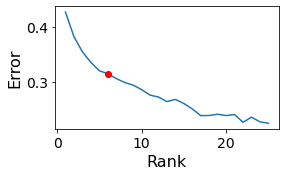

In [32]:
elbow, error = tensor.elbow_rank_selection(upper_rank=25,
                                           runs=1, # This can be increased for more robust results
                                           init='random',
                                           automatic_elbow=False,
                                           random_state=888,
                                          )

# If automatic_elbow=True, remove these two lines. To save the figure in that case,
# add the parameter filename=output_folder + 'Elbow.svg' in the previous function.
# The number of factors will be saved in tensor.rank
_ = plt.plot(*error[5], 'ro') # Here we selected a number of 6 factors.
plt.savefig(output_folder + 'Elbow.svg', dpi=300, bbox_inches='tight')

Here, the error measures how different is the original tensor from the sum of *R* rank-1 tensors used to approximate it. The idea is to find a good trade-off between a small number of factors and a small error.

![tensorapp](../figures/tensor-approx.png)


**Perform tensor factorization**

Next, we apply a tensor decomposition, specifically a non-negative canonical polyadic decomposition (CPD) (same performed in the elbow analysis). Briefly, tensor decomposition identifies a low-rank tensor (here, a rank of 6) that approximated the full tensor. This low-rank tensor can be represented as the sum of a set of rank-1 tensors (6 of them in this case). Each rank-1 tensor represents a factor in the decomposition and can be further represented as the outer product of n vectors, where n represents the number of tensor dimensions. Each vector represents one of the n tensor dimensions for that factor and its values, corresponding to individual elements in each dimension, represent the factor loadings. In our case, each factor will contain loadings for the context, LR pair, sender-cell, and receiver-cell dimensions. Those elements within each factor that contain high loadings contribute to the factor-specific communication pattern.

![tensor-fact](../figures/tensor-factorization.png)

In [33]:
tensor.compute_tensor_factorization(rank=6,
                                    init='svd', 
                                    random_state=888
                                   )
# init='svd' helps to get an global-optimal solution.
# Replace by 'random' if a memory error is obtained.

### Results

**Plot factor loadings**

After performing the tensor factorization/decomposition, a set of loadings is obtained in a factor-specific way. These loadings provide details of what elements of each dimension are important within each factor.

In [34]:
# Color palettes for each of the tensor dimensions.
cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20']

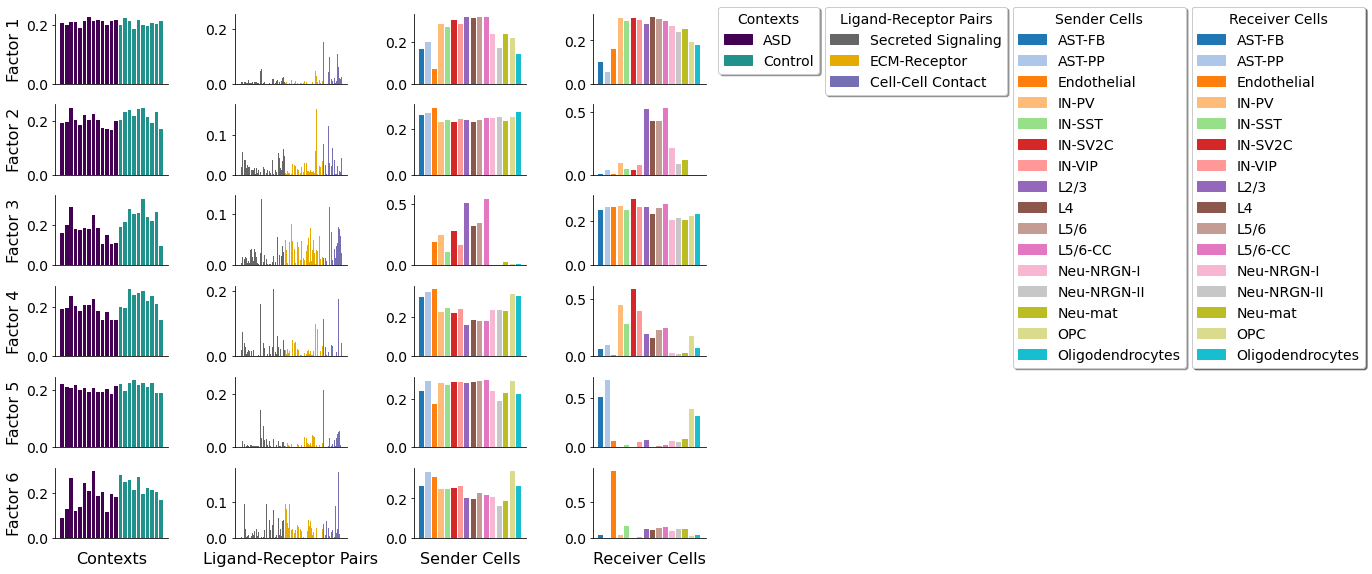

In [35]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = meta_tf, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps=cmaps,
                                                 fontsize=14,
                                                 filename=output_folder + 'Tensor-Factorization.svg'
                                                )

Each factor represents a context-dependent communication pattern. In this visualization, each row is a factor and each column is a tensor dimension in that factor (contexts, LR pairs, sender-cells, or receiver-cells). The loadings represent the contribution of each element to that pattern, and their combinations between all four dimensions represent the overall pattern. For example, in Factor 3, the identified communication pattern is stronger for Control rather than ASD patients, represented by the overall loading values of each group. Amongst the LR pairs with high loadings, L5/6-CC and L2/3 contribute most strongly to sending the communicatory signal (i.e., ligand expression) whereas there is a relatively uniform distribution of cells receiving the signal (i.e., for the receptors that correspond to highly expressed ligands, all cells have similar receptor expression). 

**Top-10 LR pairs from their factor-specific loadings**

This is for identifying key mediators of the communication patterns captured by each factor.

In [36]:
for i in range(tensor.rank):
        print(tensor.get_top_factor_elements(order_name='Ligand-Receptor Pairs', 
                                             factor_name='Factor {}'.format(i+1), 
                                             top_number=10))
        print('')

NEGR1^NEGR1    0.245580
NRXN3^NLGN1    0.236890
NRXN1^NLGN1    0.234088
CNTN1^NRCAM    0.224620
NCAM1^NCAM1    0.217748
NCAM1^NCAM2    0.207927
NRG3^ERBB4     0.194087
NRXN2^NLGN1    0.193669
NRXN3^NLGN2    0.166386
NRXN3^NLGN3    0.164240
Name: Factor 1, dtype: float64

LAMA2^SV2B    0.169643
LAMA4^SV2B    0.165446
LAMB2^SV2B    0.162802
LAMA1^SV2B    0.159729
LAMA3^SV2B    0.158929
LAMC3^SV2B    0.158480
LAMC2^SV2B    0.157097
LAMA5^SV2B    0.156795
LAMC1^SV2B    0.154253
LAMB1^SV2B    0.153554
Name: Factor 2, dtype: float64

NRG1^ERBB2&ERBB4    0.130066
NRG1^ERBB2&ERBB3    0.129851
NRG1^ERBB3          0.129237
NRG1^ERBB4          0.119872
EFNA5^EPHB2         0.114581
EFNA5^EPHA3         0.107402
EFNA5^EPHA7         0.101061
EFNA5^EPHA4         0.098312
EFNA5^EPHA5         0.097571
NECTIN3^PVR         0.096787
Name: Factor 3, dtype: float64

PTN^ALK        0.203844
PTPRM^PTPRM    0.174730
HBEGF^ERBB4    0.162865
NRG3^ERBB4     0.162113
BTC^ERBB4      0.159788
NRG4^ERBB4     0.153001


**Export Loadings for all dimensions of the 4D-communication tensor.**

***THESE VALUES CAN BE USED FOR DOWNSTREAM ANALYSES***

In [37]:
tensor.export_factor_loadings(output_folder + 'Loadings.xlsx')

Loadings of the tensor factorization were successfully saved into ./results/Loadings.xlsx
